# Recovering piecewise linear warps


## Setup

In [46]:
%pylab inline
%load_ext autoreload
%autoreload 2
np.random.seed(1234)
from scipy.ndimage.filters import convolve1d, gaussian_filter1d

# add twpca to path
import sys
sys.path.insert(0, '../')
from twpca import TWPCA
from twpca.regularizers import curvature
import itertools as itr
import seaborn as sns
sns.set_style("ticks")

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset options

In [47]:
n_time = 100
n_trial = 25
n_neuron = 50

tau = 10 # time constant for exponential decay of latent events
event_gap = 25 # average gap between events
n_events = 3 # number of events
max_jitter = 5 # maximum jitter of each event

## Generate synthetic data

Warps begin at the same speed, then change speed halfway through each trial

In [78]:
velocities = np.linspace(0.3, 5.0, n_trial)
change_idx = n_time // 2
xs = np.arange(n_time)
warps = np.empty((n_trial, n_time))
warps[:, :change_idx] = xs[:change_idx]
warps[:, change_idx:] = np.outer(velocities, xs[change_idx:]-xs[change_idx]) + xs[change_idx]

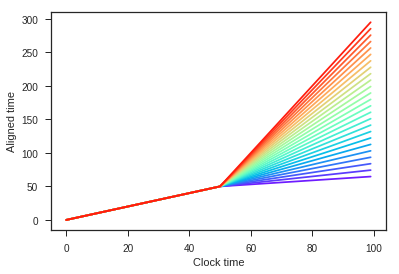

In [79]:
sns.set_palette("rainbow", n_colors=n_trial)
plot(warps.T);
xlabel('Clock time')
ylabel('Aligned time')

In [80]:
def apply_warp(time_factors, warp):
    """Warp data from the canonical space to the trial space

    Args:
        data: ndarray, shape [n_time, n_components]
        warp: ndarray, shape [shared_length]

    Returns:
        warped data: ndarray, shape [shared_length, n_components]
    """
    
    assert warp.ndim == 1
    assert len(warp) == n_time
    assert time_factors.ndim == 2
    assert time_factors.shape[0] == n_time

    # Make sure indices are in the right range.
    T = time_factors.shape[0]
    prev_idx = np.clip(np.floor(warp), 0, T-1).astype(int)
    next_idx = np.clip(prev_idx+1, 0, T-1)

    # interpolate
    prev_vals = time_factors[tuple(prev_idx), :]
    delta_val = time_factors[tuple(next_idx), :] - prev_vals
    delta_idx = warp - prev_idx
    
    # linearly interpolate and return
    return prev_vals + delta_idx[:,None]*delta_val

In [81]:
time_factor = np.sin(np.linspace(0, 2* np.pi, (n_time * 2) // 3))
time_factor = np.r_[time_factor, np.zeros(n_time - len(time_factor))]
data = np.array([apply_warp(time_factor[:, None], warp) for warp in warps])

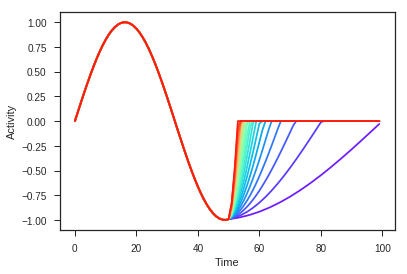

In [82]:
plot(data.squeeze().T);
xlabel('Time')
ylabel('Activity')

## twPCA options

In [416]:
n_components = 1
warp_penalty_strength = 0.0001
time_penalty_strength = 0.00

## Construct and fit twPCA model

In [417]:
# Smooth spike trains
#smoothed_spikes = gaussian_filter1d(spikes, smooth_std, axis=1)

# Add an L1 penalty on the second order finite difference of the warping functions
# This encourages the warping functions to be piecewise linear.
warp_regularizer = curvature(scale=warp_penalty_strength, power=2.0)
# Adds an L2 penatly on the second order finite difference of the temporal factors.
# Encourages the temporal factors to be smooth in time.
time_regularizer = curvature(scale=time_penalty_strength, power=2, axis=0)

model = TWPCA(n_components,
              warp_regularizer=warp_regularizer,
              time_regularizer=time_regularizer,
              fit_trial_factors=False,
              warpinit='shift')
# Fit model with gradient descent, starting with a learning rate of 1e-1 for 250 iterations,
# and then a learning rate of 1e-2 for 500 iterations
model.fit(data, lr=(1e-2, 1e-3, 1e-4, 1e-5), niter=(2500, 1000, 1000, 1000))
#model.fit(data, lr=1e-1, niter=500)
# Extract model parameters and reconstruction of the data (X_pred)
params = model.params
X_pred = model._sess.run(model.X_pred)

100%|██████████| 1000/1000 [00:01<00:00, 804.66it/s]


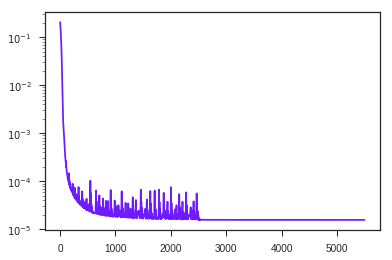

In [418]:
semilogy(model.obj_history)

In [419]:
model.obj_history[:5]

[0.20413363, 0.1970208, 0.18999101, 0.18304797, 0.17615448]

### Visualize learned warping functions

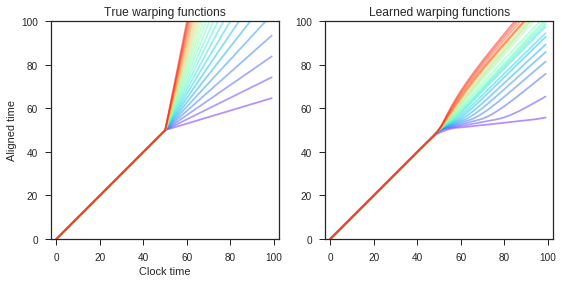

In [420]:
figure(figsize=(9,4))
ax = subplot(121)
plot(warps.T, alpha=0.5);
axis('square')
xlabel('Clock time')
ylabel('Aligned time')
title('True warping functions')

subplot(122, sharex=ax, sharey=ax)
plot(params['warp'].T, alpha=0.5);
xlim(0, 100);
ylim(0, 100)
title('Learned warping functions')

In [421]:
X_aligned = model.transform()

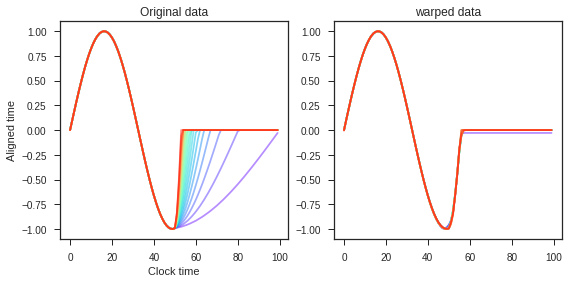

In [407]:
figure(figsize=(9,4))
ax = subplot(121)
plot(data.squeeze().T, alpha=0.5);
xlabel('Clock time')
ylabel('Aligned time')
title('Original data')

subplot(122, sharex=ax, sharey=ax)
plot(X_aligned.squeeze().T, alpha=0.5);
title('warped data')


In [408]:
warps.shape

(25, 100)

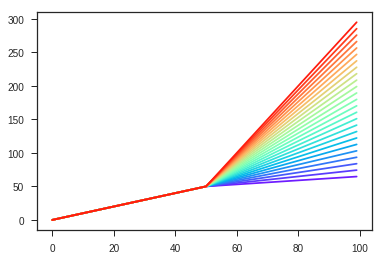

In [409]:
plot(warps.T);

In [410]:
warps.shape

(25, 100)

In [411]:
np.diff(warps, axis=1).shape

(25, 99)

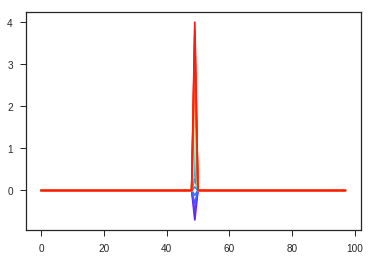

In [412]:
plot(np.diff(warps, axis=1, n=2).T);

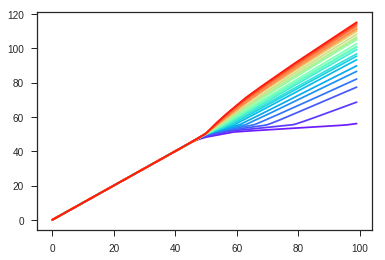

In [413]:
plot(params['warp'].T);

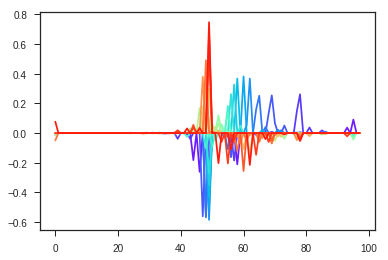

In [414]:
plot(np.diff(params['warp'], axis=1, n=2).T);

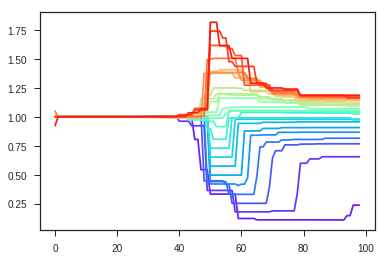

In [415]:
plot(np.diff(params['warp'], axis=1, n=1).T);

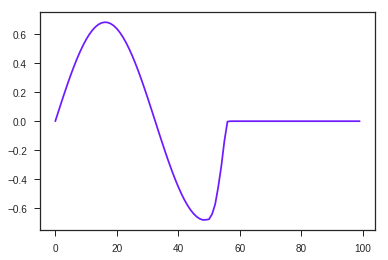

In [405]:
plot(-params['time'])